In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import hmean, norm
from nltk import word_tokenize
from collections import Counter
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np
from statistics import harmonic_mean

In [3]:
#data= load_dataset("imdb", split= "test")
#data= load_dataset("oscar", "unshuffled_deduplicated_en", split = "train", streaming= True)
#data= load_dataset("poem_sentiment","plain_text", split = "test")
data = load_dataset("c4", "en", split= "train", streaming = True)
#data_head = data.take(10)

In [4]:
#For streaming data
data_head = data.take(10000)
datadf= pd.DataFrame(data_head)

In [5]:
#for non-streaming data
#datadf = pd.json_normalize(data)

#### Looking at the top rows

In [6]:
datadf.head()

,text,timestamp,url
0,Beginners BBQ Class Taking Place in Missoula!\...,2019-04-25T12:57:54Z,https://klyq.com/beginners-bbq-class-taking-pl...
1,Discussion in 'Mac OS X Lion (10.7)' started b...,2019-04-21T10:07:13Z,https://forums.macrumors.com/threads/restore-f...
2,Foil plaid lycra and spandex shortall with met...,2019-04-25T10:40:23Z,https://awishcometrue.com/Catalogs/Clearance/T...
3,How many backlinks per day for new site?\nDisc...,2019-04-21T12:46:19Z,https://www.blackhatworld.com/seo/how-many-bac...
4,The Denver Board of Education opened the 2017-...,2019-04-20T14:33:21Z,http://bond.dpsk12.org/category/news/


#### Getting more information

In [7]:
datadf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       10000 non-null  object
 1   timestamp  10000 non-null  object
 2   url        10000 non-null  object
dtypes: object(3)
memory usage: 234.5+ KB


#### Checking for missing values

In [8]:
datadf[datadf.isnull().any(axis=1)].head()

,text,timestamp,url


In [9]:
np.sum(datadf.isnull().any(axis=1))

0

#### Count vocab size + frequencies

In [37]:
def count_vocab_frequencies(dataframe):
    """
    Based on an input pandas DataFrame with a 'text' column, 
    this function will count the occurrences of ALL words 
    (no stop word removal) and will return another DataFrame
    with the rows corresponding to the different vocabulary words
    and the column to the total count of that word.
    """
    cvec = CountVectorizer(token_pattern=u"(?u)\\b\\w+\\b")
    #needed to modify the minimum token length : https://stackoverflow.com/questions/33260505/countvectorizer-ignoring-i
    cvec.fit(dataframe.text)
    document_matrix = cvec.transform(dataframe.text)
    batches = np.linspace(0,dataframe.shape[0],100).astype(int)
    i=0
    tf = []
    while i < len(batches)-1:
        batch_result = np.sum(document_matrix[batches[i]:batches[i+1]].toarray(),axis=0)
        tf.append(batch_result)
        i += 1
    term_freq_df = pd.DataFrame([np.sum(tf,axis=0)],columns=cvec.get_feature_names()).transpose()
    term_freq_df.columns=['total']
    return(term_freq_df)

In [11]:
term_df= count_vocab_frequencies(datadf)

#### Zipf's law plot

In [40]:
def Zipf_plot(dataframe):
    """
    This function plots the correspondence of the distribution of terms
    generated by count_vocab_frequencies with the projected Zipf's law
    distribution.
    s is the value of the exponent characterizing the distribution, currently at 1.
    # TODO : see if changing this makes the distribution fit better -- 
    e.g. When Zipf's law is checked for cities, a better fit has been found with exponent s = 1.07
    """
    y_pos = np.arange(500)
    plt.figure(figsize=(10,8))
    s = 1
    expected_zipf = [dataframe.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
    plt.bar(y_pos, dataframe.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
    plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
    plt.ylabel('Frequency')
    plt.title("Top 500 tokens in the dataset, with Zipf's law in dotted red")

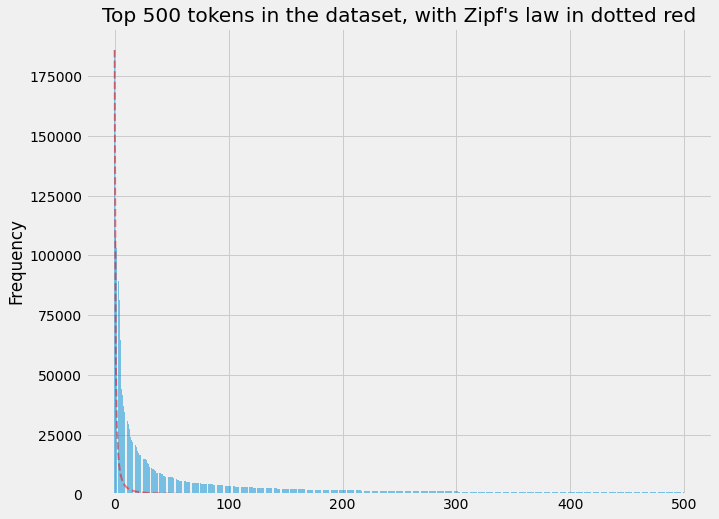

In [39]:
Zipf_plot(term_df)

### Checking which words do not respect Zipf's law

In [41]:
def Zipf_check_words(dataframe, num_words):
    """
    Checks the Zipf's law of the top [num_words] most frequent words in dataframe.
    Returns a dataframe with 3 columns:
    total = the raw number of counts 
    zipf = the projected counts according to Zipf
    difference = the *percentage* difference between the two
    """
    s = 1
    terms = pd.DataFrame(dataframe.sort_values(by='total', ascending=False)['total'][:num_words])
    expected_zipf=[dataframe.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in np.arange(num_words)]
    terms['zipf'] = [int(z) for z in expected_zipf]
    terms['difference'] = terms.apply(lambda x: ((x['total']- x['zipf'])/x['zipf']* 100), axis=1)
    return(terms)

In [42]:
zipf_df= Zipf_check_words(term_df,500)

In [22]:
zipf_df.loc[(zipf_df['difference'] >=100)].head(10)

,total,zipf,difference
a,81307,37203,118.549579
in,64422,31003,107.792794
i,29499,14309,106.156964
on,27287,13287,105.366147
as,22001,10942,101.069274
this,21663,10334,109.628411
be,20802,9790,112.482125
your,19704,9300,111.870968
or,18144,8858,104.831790
we,17153,8455,102.874039


### Checking open versus closed class words

In [26]:
#Creating the closed word list from the txt file
wordlist=open('resources/closed_EN.txt', 'r').readlines()
closedlist=[]
for l in wordlist:
    closedlist= closedlist + (l.split())
print("There are: "+ str(len(closedlist)) + " closed-class words in English.")

There are: 312 closed-class words in English.


In [50]:
def check_closed_class(dataframe, threshold):
    '''
    Based on a dataframe and a threshold, checks how many closed-class 
    words are above the threshold, and returns the dataframe sorted by 
    difference.
    '''
    closedclass= dataframe[dataframe.index.isin(closedlist)]
    closedclassthreshold= closedclass.loc[(closedclass['difference'] >=threshold)]
    print("There are: "+ str(closedclassthreshold.shape[0])+ " closed class words that are above the %s threshold" %(threshold))
    return(closedclassthreshold.sort_values(by='difference', ascending=False))

In [51]:
check_closed_class(zipf_df,100)

There are: 29 closed class words that are above the 100 threshold


,total,zipf,difference
will,14512,6414,126.255067
was,14666,6643,120.773747
a,81307,37203,118.549579
by,14810,6889,114.980404
have,16491,7750,112.787097
be,20802,9790,112.482125
your,19704,9300,111.870968
not,12675,6000,111.250000
from,15695,7440,110.954301
this,21663,10334,109.628411


In [52]:
def check_open_class(dataframe, threshold):
    closedclass= dataframe[dataframe.index.isin(closedlist)]
    openclass= dataframe[~dataframe.index.isin(closedlist)]
    openclassthreshold= openclass.loc[(openclass['difference'] >=threshold)]
    print("There are: "+ str(openclassthreshold.shape[0])+ " closed class words that are above the %s threshold" %(threshold))
    return(openclassthreshold.sort_values(by='difference', ascending=False))

In [53]:
check_open_class(zipf_df,100)

There are: 111 closed class words that are above the 100 threshold


,total,zipf,difference
news,781,372,109.946237
american,780,372,109.677419
systems,781,373,109.383378
later,781,374,108.823529
11,782,375,108.533333
...,...,...,...
15,970,485,100.000000
hand,972,486,100.000000
web,946,473,100.000000
members,944,472,100.000000
